This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
from IPython.display import display
from PIL import Image

Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.8', '1.1.0')

In [3]:
#data_dir = "/home/manojps/Documents/deep_learning/Project"
data_dir = "/home/msaha/Documents/deep_learning/project"
#data_dir = "C:\\Users\\msaha\\Documents\\Deep_Learning\\Project\\"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

#train_bson_path = os.path.join(data_dir, "train_example.bson")
#num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

print(test_bson_path)

/home/msaha/Documents/deep_learning/project/test.bson


# Part 1: Create lookup tables

The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

## Lookup table for categories

In [4]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


Create dictionaries for quick lookup of `category_id` to `category_idx` mapping.

In [5]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [6]:
cat2idx, idx2cat = make_category_tables()

In [7]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

## Read the BSON files

We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

Note: this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).

In [8]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [9]:
#%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [07:15<00:00, 16234.41it/s]


CPU times: user 1min 53s, sys: 32.4 s, total: 2min 26s
Wall time: 7min 25s


In [ ]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)

In [10]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [11]:
#train_offsets_df.to_csv("train_offsets.csv")

In [12]:
# How many products?
len(train_offsets_df)

7069896

In [13]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [14]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

## Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [15]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if `drop_percentage` > 0, the progress bar doesn't go all the way.)

In [16]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.8)

7069896it [00:07, 939739.06it/s]
 20%|█▉        | 1410843/7069896 [00:47<03:10, 29636.11it/s]


In [17]:
train_images_df.head()

,product_id,category_idx,img_idx
0,5215767,619,0
1,21505415,619,0
2,23572560,619,0
3,18179533,619,0
4,20435565,619,0


In [18]:
val_images_df.head()

,product_id,category_idx,img_idx
0,22291005,619,0
1,3972587,619,0
2,13173142,619,0
3,13173142,619,1
4,1983191,619,0


In [19]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 1977575
Number of validation images: 490057
Total images: 2467632


Are all categories represented in the train/val split? (Note: if the drop percentage is high, then very small categories won't have enough products left to make it into the validation set.)

In [20]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 4835)

Quickly verify that the split really is approximately 80-20:

In [21]:
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
num_val / num_train

0.24233983286908078

Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if `drop_percentage` > 0.)

Save the lookup tables as CSV so that we don't need to repeat the above procedure again.

In [22]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [23]:
categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

/home/msaha/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [23]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
             #changed from 'index_array' to 'index_array[0]'
             #before: return self._get_batches_of_transformed_samples(index_array)
        return self._get_batches_of_transformed_samples(index_array[0]) 

In [24]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [25]:
import threading
lock = threading.Lock()

Create a generator for training and a generator for validation.

In [26]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 1000

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 1977575 images belonging to 5270 classes.
Found 490057 images belonging to 5270 classes.


How fast is the generator? Create a single batch:

In [27]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 1.25 s, sys: 132 ms, total: 1.38 s
Wall time: 10 s


Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

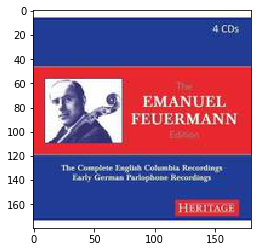

In [28]:
plt.imshow(bx[-1].astype(np.uint8))

In [29]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                 MUSIQUE
category_level2                      CD
category_level3    CD MUSIQUE CLASSIQUE
category_idx                       3956
Name: 1000018290, dtype: object

In [30]:
%time bx, by = next(val_gen)

CPU times: user 1.2 s, sys: 120 ms, total: 1.32 s
Wall time: 9.86 s


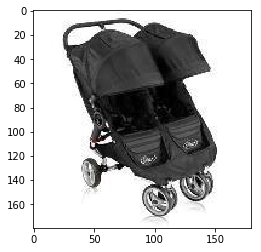

In [31]:
plt.imshow(bx[-1].astype(np.uint8))

In [32]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                   PUERICULTURE
category_level2               PROMENADE-VOYAGE
category_level3    POUSSETTE-CHASSIS POUSSETTE
category_idx                              4298
Name: 1000000422, dtype: object

# Part 3: Training

Create a very simple Keras model and train it, to test that the generators work.

In [33]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5270 classes
predictions = Dense(5270, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
#batch_size = 1
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 5,
                    class_weight = 'auto',
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
#                     workers = 8,
                   verbose =1)

Epoch 1/5
   1/1977 [..............................] - ETA: 119832s - loss: 8.6451 - acc: 0.0000e+00 - top_k_categorical_accuracy: 0.0020

In [ ]:
# To evaluate on the validation set:
#score = model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

In [ ]:
model.evaluate_generator(val_gen, steps=num_val_images // batch_size)
#print("Accuracy = ", score[1])

In [ ]:
print(len(train_images_df), len(val_images_df))

# Part 4: Test set predictions

Note: The previous version of this kernel used `BSONIterator` to load the test set images in batches. However, storing the prediction results takes up a huge amount of memory. 

I suggest using a different kind of generator instead, something like the following:

```
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])

        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)
        
        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()
        
submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)        
```